# CAI Lab Session 9: simulation of SI model of contagion over contact networks

In this session you will:

- learn about the `SI` epidemic model of contagion
- simulate `SI` epidemic spreading over different network topologies
- monitor fraction of infected nodes over time

## 1. The SI epidemic model

In classic epidemiology, it is assumed that every individual has an equal chance of coming into contact with every other individual in the population.
This is, however, highly unrealistic and we can improve on this assumption by simulating the spread of an infection over a realistic contact social network.
In such a network, nodes are individuals susceptible to becoming sick and edges correspond to their chance of making physical contact and thus getting infected.

The SI model is one of the most simple models used for studying infection and assumes that individuals can be in one of two states: _infected_, or _susceptible_ to infection (i.e. not infected yet). 
Initially, all individuals (or nodes) are susceptible and at time $t=0$ some node becomes infected (this node corresponds to _patient 0_). 
Over time, as nodes come into contact with other nodes, they may become infected too and can spread the disease further to their contacts and so on.

An important parameter of this model is the _infection rate_ $\alpha$ which is the probability that an infected node infects a neighbouring one after contact. 
Clearly, $0\leq\alpha\leq 1$ and the closer it is to 1 the faster the infection will spread. Additionally, the underlying topology of the contact network also 
plays a role in how the infection spreads and this is what you have to study in this session.


## 2. Simulating the SI epidemic model at discrete time steps

You will have to implement the simulation of the spreading of the SI model over diverse network topologies using discrete time steps. Thus, given a contact network $G$, we have that:

- at time $t = 0$ a random node becomes infected
- after each time step (that is, one infection round), each infected node potentially infects neighboring nodes independently with probability $\alpha$

You can use the `igraph` library from last session to help you with the generation of contact networks, managing of nodes' statuses, etc. 
Also, we will be using undirected graphs as contact networks.

The quantity of interest to monitor will be the fraction of infected nodes over time, which should grow over time since infected nodes never recover in this model.

>   _You should be careful when implementing your simulation; please make sure that the updates of the nodes’ statuses are done in parallel, that is, to update the status for time t only statuses of time t−1 of the other nodes are considered._


## 3. Functionality of `igraph` that may be of help

This library provides functions to generate networks, traverse them, assign attributes to nodes, and selecting nodes' neighborhoods. 
This is going to be highly useful for the implementation of the epidemic simulation. 
Below you can find some examples on how to do some of the things mentioned above; please consult [`igraph`'s documentation](https://python.igraph.org/en/stable/) for more detailed information.

#### graph generation:

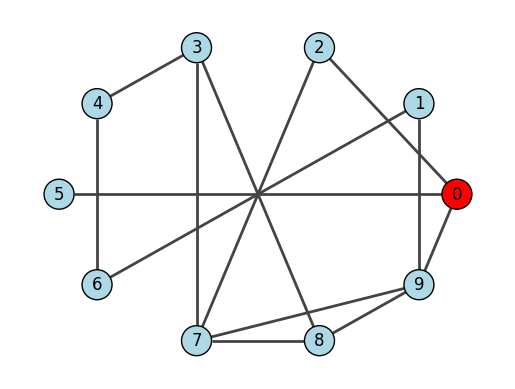

In [232]:
import igraph as ig
from igraph import Graph
import matplotlib.pyplot as plt

# generating an ER graph with n=10 nodes and probability p=0.3 of adding edges between each pair of nodes
g = ig.Graph.Erdos_Renyi(10, 0.3)

# visualizing the generated graph
g.vs['color'] = 'lightblue'
g.vs[0]['color'] = 'red'

fig, ax = plt.subplots()
ig.plot(
    g,
    target=ax,
    vertex_size=30,
    vertex_label=range(g.vcount()),
    layout=g.layout("circle")
);

#### values and attributes of nodes:

In [233]:

# set value 'False' to attribute 'foo' for all nodes in graph g
g.vs['foo'] = False

# set value 'True' to attribute 'foo' for node 0
g.vs[0]['foo'] = True

# print node 0 attributes
print(g.vs[0].attributes())

# print node 0 value for attribute 'foo'
print(g.vs[0]['foo'])

# print all nodes' vales for attribute 'foo'
print(g.vs['foo'])

{'color': 'red', 'foo': True}
True
[True, False, False, False, False, False, False, False, False, False]


#### selecting nodes by attribute value:

In [234]:
nodes_subset = g.vs.select(foo=True)
for v in nodes_subset:
    print(v.index)
    print(v.attributes())

0
{'color': 'red', 'foo': True}


#### finding neighbors

In [235]:
nei = g.vs[0].neighbors()
for v in nei:
    print(v.index)
    print(v.attributes())

2
{'color': 'lightblue', 'foo': False}
5
{'color': 'lightblue', 'foo': False}
9
{'color': 'lightblue', 'foo': False}


## 4. Your tasks



Study evolution of infection over time for different topologies. Here, there are several things that you may play with (be creative!):

- underlying contact networks: you should consider at least the ones seen in class (Erdös-Rényii, Watts-Strogatz, and Barabasi-Albert) but there are others already implemented that may be of interest (Tree, Lattice, etc.)
- patient 0 selection: random selection, or select patient 0 with smallest/largest centrality, etc.
- infection rate: how does the infection rate affect speed of spreading for different topologies?

Things that may be of importance:

- graphs should be large enough (at least $n=1000$ nodes) so that interesting things may happen
- graphs should be _connected_ so that all nodes may be reachable by patient 0

In [236]:
import random
import numpy as np
import pandas as pd
import altair as alt

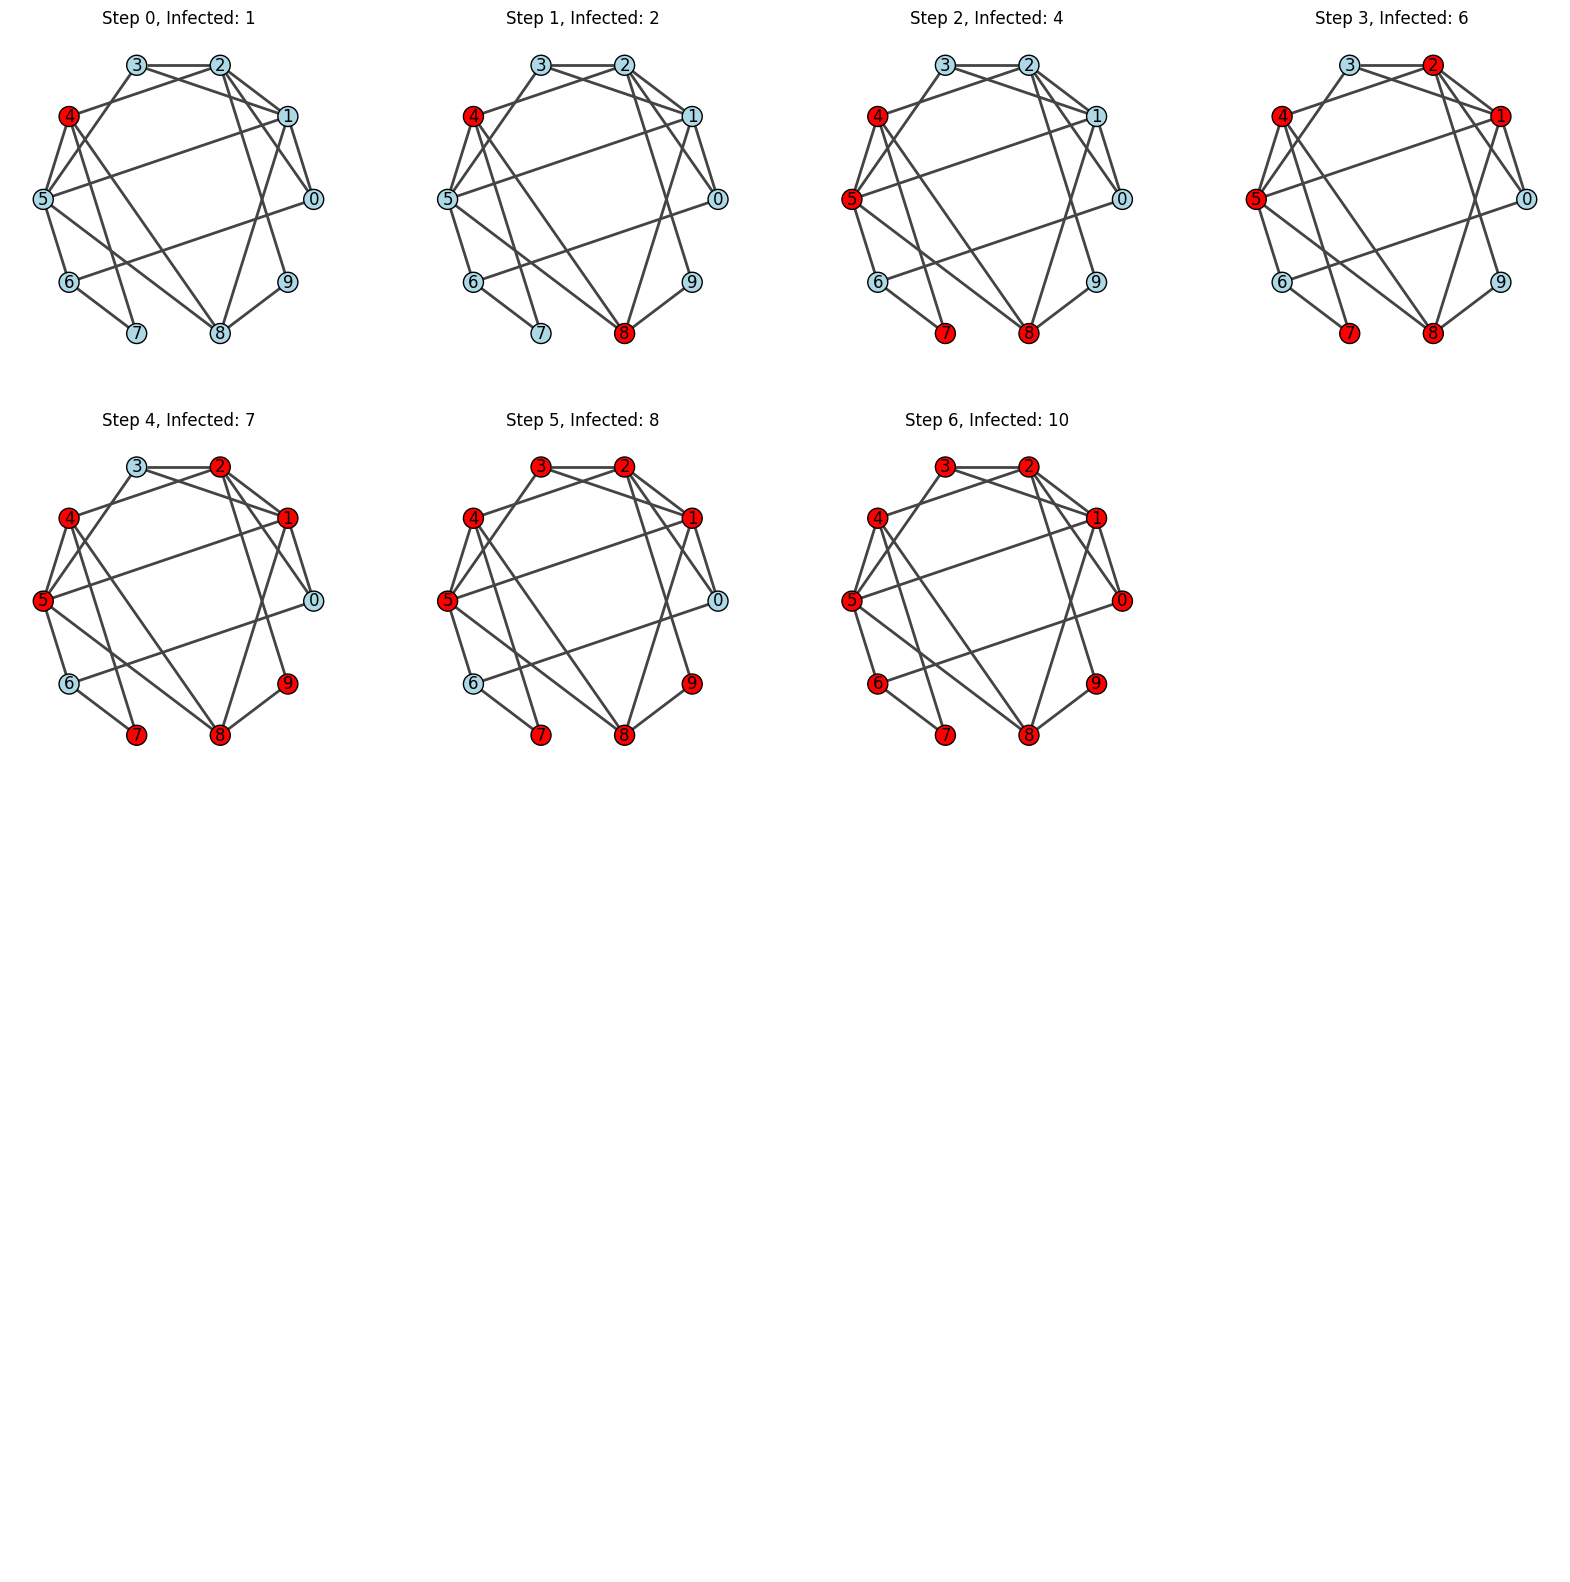

In [237]:
def toy_simulation(g, alpha): 
    g.vs['infected'] = False
    g.vs['color'] = 'lightblue'

    initial_node = random.choice(g.vs).index

    g.vs[initial_node]['infected'] = True
    g.vs[initial_node]['color'] = 'red'

    steps = 0

    fig, ax = plt.subplots(4, 4, figsize=(20, 20))
     
    while len(g.vs.select(infected=True)) < g.vcount():
        for v in g.vs.select(infected=True):
            for neighbor in v.neighbors():
                if neighbor['infected'] == False and random.random() < alpha:
                    neighbor['infected'] = True
                    neighbor['color'] = 'red'
        
        ig.plot(
            g,
            target=ax[steps // 4, steps % 4],
            vertex_size=20,
            vertex_label=range(g.vcount()),
            layout=g.layout("circle")
        );
        
        ax[steps // 4, steps % 4].set_title(f"Step {steps}, Infected: {len(g.vs.select(infected=True))}")
        
        steps += 1
    
    for i in range(steps, 16):
        ax[i // 4, i % 4].axis('off')

g = ig.Graph.Erdos_Renyi(10, 0.5)
toy_simulation(g, 0.2)

In [238]:
def select_initial_node(g: Graph, method: str = 'random') -> int:
  """
  Selects an initial node for the spread of the infection. The selection is based on the method parameter.

  Parameters
  ----------
  g : igraph.Graph
    The graph on which the infection will spread.
  method : str
    The method used to select the initial node. The possible values are:
      'random'
      'max degree'
      'min degree'
      'max betweenness'
      'min betweenness'
      'max closeness'
      'min closeness'

  Returns
  -------
  int
    The index of the selected node.
  """
  
  if method == 'random':
    return random.choice(g.vs).index
  if method == 'max degree':
    return g.vs.degree().index(max(g.vs.degree()))
  if method == 'min degree':
    return g.vs.degree().index(min(g.vs.degree()))
  if method == 'max betweenness':
    return g.vs.betweenness().index(max(g.vs.betweenness()))
  if method == 'min betweenness':
    return g.vs.betweenness().index(min(g.vs.betweenness()))
  if method == 'max closeness':
    return g.vs.closeness().index(max(g.vs.closeness()))
  if method == 'min closeness':
    return g.vs.closeness().index(min(g.vs.closeness()))


def si_model_simulation(g: Graph, alpha: float = 0.5, initial_node_method: str = 'random') -> int:
	"""
	Simulates the spread of an infection on a graph using the SI model.

	Parameters
	----------
	g : igraph.Graph
	The graph on which the infection will spread.
	alpha : float
	The probability of a node to get infected.
	initial_node_method : int
	The method used to select the initial node. The possible values are:
		1 - random
		2 - max degree
		3 - min degree
		4 - max betweenness
		5 - min betweenness
		6 - max closeness
		7 - min closeness

	Returns
	-------
	int
	The number of steps needed to infect all nodes.
	"""

	g.vs['infected'] = False

	initial_node_idx = select_initial_node(g, initial_node_method)
	g.vs[initial_node_idx]['infected'] = True

	t = 0
	stop_condition = 0
	infected_t = g.vs.select(infected=True)
	infected_evol = [len(infected_t)]

	while len(infected_t) < g.vcount() and stop_condition < 1000:
		for v in infected_t:
			for neighbor in v.neighbors():
				if neighbor['infected'] == False and random.random() < alpha:
					neighbor['infected'] = True
        
		infected_t1 = g.vs.select(infected=True)
		if infected_t == len(infected_t1):
			stop_condition += 1
		else:
			stop_condition = 0  

		t += 1
		infected_t = infected_t1
		infected_evol.append(len(infected_t))

	return t, [n/len(g.vs) for n in infected_evol]

In [239]:
n = 1000
m = 5000

In [240]:
connected = False
while not connected:
    ER = Graph.Erdos_Renyi(n, m=m)
    connected = ER.is_connected()

connected = False
while not connected:
    BA = Graph.Barabasi(n, m=(m//n))
    connected = BA.is_connected()
    
connected = False
while not connected:
    WS = Graph.Watts_Strogatz(1, n, m//n, 0.1)
    connected = WS.is_connected()

In [241]:
methods = ['random', 'max degree', 'min degree', 'max betweenness', 'min betweenness', 'max closeness', 'min closeness']
alphas = np.arange(0.1, 1, 0.05)
graphs = [ER, BA, WS]

results = {}
infected_evols = {}

for i, G in enumerate(graphs):
  for a in alphas:
    for m in methods:
      print(f'Graph: {i}, alpha: {round(a, 3)}, method: {m}')
      results[(i, round(a, 3), m)], infected_evols[(i, round(a, 3), m)] = si_model_simulation(G, a, m)

Graph: 0, alpha: 0.1, method: random
Graph: 0, alpha: 0.1, method: max degree
Graph: 0, alpha: 0.1, method: min degree
Graph: 0, alpha: 0.1, method: max betweenness
Graph: 0, alpha: 0.1, method: min betweenness
Graph: 0, alpha: 0.1, method: max closeness
Graph: 0, alpha: 0.1, method: min closeness
Graph: 0, alpha: 0.15, method: random
Graph: 0, alpha: 0.15, method: max degree
Graph: 0, alpha: 0.15, method: min degree
Graph: 0, alpha: 0.15, method: max betweenness
Graph: 0, alpha: 0.15, method: min betweenness
Graph: 0, alpha: 0.15, method: max closeness
Graph: 0, alpha: 0.15, method: min closeness
Graph: 0, alpha: 0.2, method: random
Graph: 0, alpha: 0.2, method: max degree
Graph: 0, alpha: 0.2, method: min degree
Graph: 0, alpha: 0.2, method: max betweenness
Graph: 0, alpha: 0.2, method: min betweenness
Graph: 0, alpha: 0.2, method: max closeness
Graph: 0, alpha: 0.2, method: min closeness
Graph: 0, alpha: 0.25, method: random
Graph: 0, alpha: 0.25, method: max degree
Graph: 0, alpha:

In [242]:
df = pd.DataFrame.from_dict(results, orient='index')
df.reset_index(inplace=True)

df[['graph', 'alpha', 'method']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df = df.drop(columns=['index'])

df['graph'] = df['graph'].replace({0: 'ER', 1: 'BA', 2: 'WS'})
df = df.rename(columns={0: 'steps'})

df.head()

,steps,graph,alpha,method
0,21,ER,0.1,random
1,22,ER,0.1,max degree
2,40,ER,0.1,min degree
3,21,ER,0.1,max betweenness
4,33,ER,0.1,min betweenness


In [243]:
def create_heatmap(df: pd.DataFrame, G: Graph):
	"""
	Creates a heatmap of the number of steps needed to infect all nodes for each combination of alpha and method.

	Parameters
	----------
	df : pandas.DataFrame
	The dataframe containing the results of the simulations.
	graph : int
	The index of the graph to be plotted.

	Returns
	-------
	altair.Chart
	The heatmap.
	"""

	heat = alt.Chart(df[df['graph'] == G]).mark_rect().encode(
		x = alt.X('alpha:O',
					title='alpha',
					axis=alt.Axis(labelAngle=0)),
		y = alt.Y('method:O'),
		color = alt.Color('steps:Q', title='steps')
	).properties(
		width=600,
		height=240,
		title=f'SI model simulation on {G} network'
	)

	text = heat.mark_text(color='black').encode(
		text='steps:Q'
	)

	return heat + text

(create_heatmap(df, 'ER') & create_heatmap(df, 'BA')) | create_heatmap(df, 'WS')  

alt.HConcatChart(...)

In [244]:
df = pd.DataFrame.from_dict(infected_evols, orient='index')
df.reset_index(inplace=True)

df[['graph', 'alpha', 'method']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df = df.drop(columns=['index'])

df['graph'] = df['graph'].replace({0: 'ER', 1: 'BA', 2: 'WS'})

df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,graph,alpha,method
0,0.001,0.004,0.005,0.010,0.017,0.033,0.063,0.121,0.224,0.369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER,0.1,random
1,0.001,0.001,0.003,0.006,0.013,0.020,0.041,0.080,0.130,0.237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER,0.1,max degree
2,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.999,1.0,NaN,NaN,NaN,NaN,NaN,ER,0.1,min degree
3,0.001,0.002,0.005,0.009,0.014,0.031,0.049,0.083,0.148,0.258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER,0.1,max betweenness
4,0.001,0.001,0.001,0.001,0.002,0.002,0.003,0.007,0.012,0.022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER,0.1,min betweenness


In [245]:
new_data = []

for _, row in df.iterrows():
    method = row['method']
    graph = row['graph']
    alpha = row['alpha']
    for i in range(df.shape[1]-3):
        new_data.append([i, graph, method, alpha, row[i]])

new_columns = ['Steps', 'Graph', 'Method', 'Alpha', 'Infected Fraction']
new_df = pd.DataFrame(new_data, columns=new_columns)

new_df.head()

,Steps,Graph,Method,Alpha,Infected Fraction
0,0,ER,random,0.1,0.001
1,1,ER,random,0.1,0.004
2,2,ER,random,0.1,0.005
3,3,ER,random,0.1,0.010
4,4,ER,random,0.1,0.017


In [246]:
# pip install "vegafusion[embed]"

In [247]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [248]:
def create_lineplot(df: pd.DataFrame, G: Graph):
    """
    Creates a lineplot of the fraction of infected nodes for each combination of alpha and method.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the results of the simulations.
    graph : str
        The name of the graph to be plotted.

    Returns
    -------
    altair.Chart
        The lineplot.
    """
    methods = df['Method'].unique()

    charts = []
    for m in methods:
        c = alt.Chart(new_df[new_df['Graph'] == G]).mark_line(
            opacity=0.8
        ).transform_filter(
            alt.datum.Method == m
        ).encode(
            x = alt.X('Steps:Q', title='t'),
            y = alt.Y('Infected Fraction:Q', title='Fraction of infected nodes'),
            color = alt.Color('Alpha:N', title='alpha')
        ).facet(
            column = alt.Column('Method:N', title='')
        )

        charts.append(c)

    final_chart = alt.vconcat(alt.hconcat(charts[0], charts[1], charts[2]), alt.hconcat(charts[3], charts[4], charts[5]), charts[6])
        
    return final_chart

In [249]:
create_lineplot(new_df, 'ER')

alt.VConcatChart(...)

In [250]:
create_lineplot(new_df, 'BA')

alt.VConcatChart(...)

In [251]:
create_lineplot(new_df, 'WS')

alt.VConcatChart(...)

## 5. Rules of delivery

- To be solved in _pairs_.

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session.

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report listing the solutions to the exercises proposed. Include things like the important parts of your implementation (data structures used for representing objects, algorithms used, etc). You are welcome to add conclusions and findings that depart from what we asked you to do. We encourage you to discuss the difficulties you find; this lets us give you help and also improve the lab session for future editions.

- Turn the report to PDF. Make sure it has your names, date, and title. Include your code in your submission.

- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html) _before January 10th, 2024_.